# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.286405 -0.070572  0.0  0.429721  0.948027 -0.973526  2  3  11.364124   
1 -0.362671 -1.082411  0.0  0.251696 -1.252510 -2.175713  0  0  -4.450796   
2 -0.680469  0.062573  0.0  0.168424 -0.142137 -0.913094  1  2   3.363226   
3 -0.387097 -0.014917  0.0  0.170385  0.749806  0.277708  1  3   9.071883   
4 -1.712933 -1.730509  0.0  0.223008 -0.279014 -2.403685  0  0  -3.807242   

            y  
0  105.789983  
1  -22.275282  
2   27.595845  
3   85.023781  
4   14.366949  
True causal estimate is 5.357182866030086


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

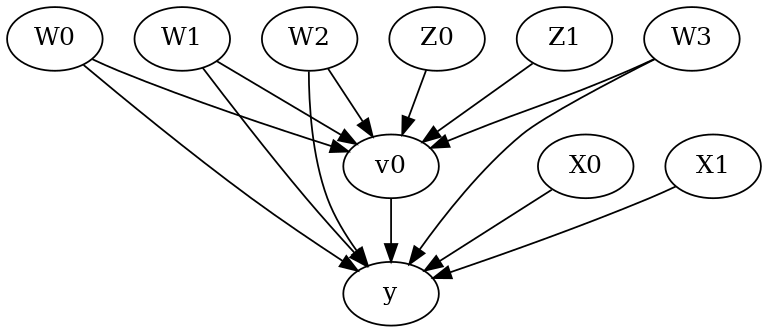

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 5.3572477127759
### Conditional Estimates
__categorical__X1  __categorical__X0           
(-4.633, -1.503]   (-4.4110000000000005, -1.16]    -7.197404
                   (-1.16, -0.571]                 -4.392715
                   (-0.571, -0.0417]               -2.538578
                   (-0.0417, 0.525]                -0.330966
                   (0.525, 3.837]                   2.627335
(-1.503, -0.916]   (-4.4110000000000005, -1.16]    -2.598148
                   (-1.16, -0.571]                  0.552823
                   (-0.571, -0.0417]             

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 11.662447734075922
Effect estimates: [ 6.46414574  8.66496824 11.95107709  8.72597349  9.56379114  2.55583311
 15.54022702 16.99290333 15.20973736 10.64409212 20.53385919 15.88738295
 14.8417168  10.98643489 14.19102374 12.00898261 14.95793264  9.9243251
  9.66681471 18.6232577  12.71967214 22.79863858  5.69667008 10.25455932
 19.2088114  12.13632374  3.35602854  6.55728094  7.50643465 21.27651451
 16.49518169  6.58389613 17.82388605  6.59020196 21.80248808 12.45728569
 15.5651037  13.58550742 11.98648396  9.37160449 20.04286845  7.35

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 5.357182866030086


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: 

## Estimate
Mean value: 5.347669916064277
Effect estimates: [ 8.60103114  2.82524032  7.92971808 ... 15.47301072  8.34761245
  6.02774406]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 5.366822830453533
Effect estimates: [ 8.62583572  2.84243519  7.98252038 ... 15.39094597  8.22441186
  6.05370896]
95.0% confidence interval: (array([ 8.72431102,  2.79324637,  8.07099452, ..., 15.50167809,
        8.1189053 ,  6.10275521]), array([ 8.89614054,  2.90865626,  8.25354942, ..., 15.86437553,
        8.47468441,  6.2154502 ]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[14.5820909  13.13364504 16.13604129 16.07734527 15.33487912 13.96131198
 12.8320655  12.6208062  13.45048233 12.71087602]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.563924 -0.481408  0.0  0.739670  0.046337 -0.032936 -1.956713   
1     0.086258 -0.897586  0.0  0.860280 -1.947556  1.682707  2.536922   
2     0.525049 -0.839004  0.0  0.313768 -0.793818  0.813267  0.955934   
3     0.050582 -0.503743  0.0  0.476477 -0.839662  2.163678  2.092744   
4     0.454220  1.775714  0.0  0.048650 -0.599900  2.490494  0.379131   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.362832  0.866050  0.0  0.784726 -1.588339  1.506933  0.599215   
9996 -0.206822 -1.049066  0.0  0.243014 -0.925162  0.561306  1.875331   
9997  0.072345  1.279603  0.0  0.231570  0.557820  3.151815  1.138445   
9998 -0.579038 -0.240833  0.0  0.524018 -0.245782  0.315775  0.540064   
9999  0.162467  0.326294  0.0  0.583842 -1.858869  0.362558  1.403280   

            W3  v0  y  
0    -0.252001   1  1  
1    -0.963894   1  1  
2    -0.142707   1  1  
3    -1.879610   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 0.6582761477393826
Effect estimates: [0.62223463 0.60773126 0.60772    ... 0.69748664 0.63845857 0.65772192]

True causal estimate is 0.4727


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-11-09 11:40:56.781361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 11:40:56.957387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 11:40:56.957435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-11-09 11:40:56.989045: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-09 11:40:58.009172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-09 11:40:58.009388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-09 11:40:58.009409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-11-09 11:40:59.273549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-09 11:40:59.273602: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 11:40:59.273636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5cb5a9d6ca49): /proc/driver/nvidia/version does not exist
2022-11-09 11:40:59.274333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:46 - loss: 53.6880

 24/313 [=>............................] - ETA: 0s - loss: 20.4602  

 48/313 [===>..........................] - ETA: 0s - loss: 12.7121

 71/313 [=====>........................] - ETA: 0s - loss: 9.8729 

 95/313 [========>.....................] - ETA: 0s - loss: 8.3028

120/313 [==========>...................] - ETA: 0s - loss: 7.2770

138/313 [============>.................] - ETA: 0s - loss: 6.7499

160/313 [==============>...............] - ETA: 0s - loss: 6.2458

178/313 [================>.............] - ETA: 0s - loss: 5.9245

203/313 [==================>...........] - ETA: 0s - loss: 5.5552

226/313 [====================>.........] - ETA: 0s - loss: 5.2780

249/313 [======================>.......] - ETA: 0s - loss: 5.0362

272/313 [=========================>....] - ETA: 0s - loss: 4.8333

297/313 [===========================>..] - ETA: 0s - loss: 4.6458

313/313 [==============================] - 2s 2ms/step - loss: 4.5375


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 2.3255

 19/313 [>.............................] - ETA: 0s - loss: 2.5183

 43/313 [===>..........................] - ETA: 0s - loss: 2.5286

 68/313 [=====>........................] - ETA: 0s - loss: 2.5103

 92/313 [=======>......................] - ETA: 0s - loss: 2.4736

118/313 [==========>...................] - ETA: 0s - loss: 2.4518

141/313 [============>.................] - ETA: 0s - loss: 2.4458

164/313 [==============>...............] - ETA: 0s - loss: 2.4219

187/313 [================>.............] - ETA: 0s - loss: 2.4081

212/313 [===================>..........] - ETA: 0s - loss: 2.3861

234/313 [=====================>........] - ETA: 0s - loss: 2.3654

258/313 [=======================>......] - ETA: 0s - loss: 2.3527

281/313 [=========================>....] - ETA: 0s - loss: 2.3386

306/313 [============================>.] - ETA: 0s - loss: 2.3243

313/313 [==============================] - 1s 2ms/step - loss: 2.3195


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.3839

 25/313 [=>............................] - ETA: 0s - loss: 2.1558

 49/313 [===>..........................] - ETA: 0s - loss: 2.1558

 74/313 [======>.......................] - ETA: 0s - loss: 2.1533

 98/313 [========>.....................] - ETA: 0s - loss: 2.1655

122/313 [==========>...................] - ETA: 0s - loss: 2.1532

147/313 [=============>................] - ETA: 0s - loss: 2.1519

173/313 [===============>..............] - ETA: 0s - loss: 2.1455

198/313 [=================>............] - ETA: 0s - loss: 2.1512

223/313 [====================>.........] - ETA: 0s - loss: 2.1486

246/313 [======================>.......] - ETA: 0s - loss: 2.1445

269/313 [========================>.....] - ETA: 0s - loss: 2.1387

293/313 [===========================>..] - ETA: 0s - loss: 2.1378

313/313 [==============================] - 1s 2ms/step - loss: 2.1385


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 1.9789

 26/313 [=>............................] - ETA: 0s - loss: 2.0698

 50/313 [===>..........................] - ETA: 0s - loss: 2.1031

 74/313 [======>.......................] - ETA: 0s - loss: 2.0877

 98/313 [========>.....................] - ETA: 0s - loss: 2.1025

123/313 [==========>...................] - ETA: 0s - loss: 2.0950

144/313 [============>.................] - ETA: 0s - loss: 2.0900

160/313 [==============>...............] - ETA: 0s - loss: 2.0916

182/313 [================>.............] - ETA: 0s - loss: 2.0959

204/313 [==================>...........] - ETA: 0s - loss: 2.0931

226/313 [====================>.........] - ETA: 0s - loss: 2.0951

249/313 [======================>.......] - ETA: 0s - loss: 2.0966

275/313 [=========================>....] - ETA: 0s - loss: 2.0948

301/313 [===========================>..] - ETA: 0s - loss: 2.0924

313/313 [==============================] - 1s 2ms/step - loss: 2.0904


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.3356

 27/313 [=>............................] - ETA: 0s - loss: 2.0437

 45/313 [===>..........................] - ETA: 0s - loss: 2.0551

 70/313 [=====>........................] - ETA: 0s - loss: 2.0818

 95/313 [========>.....................] - ETA: 0s - loss: 2.0755

119/313 [==========>...................] - ETA: 0s - loss: 2.0613

143/313 [============>.................] - ETA: 0s - loss: 2.0557

165/313 [==============>...............] - ETA: 0s - loss: 2.0593

186/313 [================>.............] - ETA: 0s - loss: 2.0567

209/313 [===================>..........] - ETA: 0s - loss: 2.0566

231/313 [=====================>........] - ETA: 0s - loss: 2.0605

255/313 [=======================>......] - ETA: 0s - loss: 2.0611

278/313 [=========================>....] - ETA: 0s - loss: 2.0651

303/313 [============================>.] - ETA: 0s - loss: 2.0637

313/313 [==============================] - 1s 2ms/step - loss: 2.0639


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 1.9959

 26/313 [=>............................] - ETA: 0s - loss: 2.0332

 49/313 [===>..........................] - ETA: 0s - loss: 2.0546

 72/313 [=====>........................] - ETA: 0s - loss: 2.0527

 95/313 [========>.....................] - ETA: 0s - loss: 2.0515

114/313 [=========>....................] - ETA: 0s - loss: 2.0558

137/313 [============>.................] - ETA: 0s - loss: 2.0475

160/313 [==============>...............] - ETA: 0s - loss: 2.0441

186/313 [================>.............] - ETA: 0s - loss: 2.0435

211/313 [===================>..........] - ETA: 0s - loss: 2.0465

237/313 [=====================>........] - ETA: 0s - loss: 2.0396

256/313 [=======================>......] - ETA: 0s - loss: 2.0371

279/313 [=========================>....] - ETA: 0s - loss: 2.0374

298/313 [===========================>..] - ETA: 0s - loss: 2.0369

313/313 [==============================] - 1s 2ms/step - loss: 2.0340


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.1953

 25/313 [=>............................] - ETA: 0s - loss: 2.0721

 49/313 [===>..........................] - ETA: 0s - loss: 2.0618

 73/313 [=====>........................] - ETA: 0s - loss: 2.0507

 96/313 [========>.....................] - ETA: 0s - loss: 2.0397

120/313 [==========>...................] - ETA: 0s - loss: 2.0409

144/313 [============>.................] - ETA: 0s - loss: 2.0435

169/313 [===============>..............] - ETA: 0s - loss: 2.0432

194/313 [=================>............] - ETA: 0s - loss: 2.0425

219/313 [===================>..........] - ETA: 0s - loss: 2.0405

242/313 [======================>.......] - ETA: 0s - loss: 2.0400

266/313 [========================>.....] - ETA: 0s - loss: 2.0374

289/313 [==========================>...] - ETA: 0s - loss: 2.0348

308/313 [============================>.] - ETA: 0s - loss: 2.0325

313/313 [==============================] - 1s 2ms/step - loss: 2.0319


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 1.9415

 26/313 [=>............................] - ETA: 0s - loss: 1.9791

 50/313 [===>..........................] - ETA: 0s - loss: 2.0096

 75/313 [======>.......................] - ETA: 0s - loss: 2.0195

 99/313 [========>.....................] - ETA: 0s - loss: 1.9989

122/313 [==========>...................] - ETA: 0s - loss: 2.0029

145/313 [============>.................] - ETA: 0s - loss: 2.0082

169/313 [===============>..............] - ETA: 0s - loss: 2.0053

191/313 [=================>............] - ETA: 0s - loss: 2.0069

208/313 [==================>...........] - ETA: 0s - loss: 2.0050

232/313 [=====================>........] - ETA: 0s - loss: 2.0025

256/313 [=======================>......] - ETA: 0s - loss: 2.0029

281/313 [=========================>....] - ETA: 0s - loss: 2.0044

307/313 [============================>.] - ETA: 0s - loss: 1.9990

313/313 [==============================] - 1s 2ms/step - loss: 1.9998


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 1.9466

 26/313 [=>............................] - ETA: 0s - loss: 1.9665

 50/313 [===>..........................] - ETA: 0s - loss: 1.9936

 74/313 [======>.......................] - ETA: 0s - loss: 1.9859

 97/313 [========>.....................] - ETA: 0s - loss: 1.9999

121/313 [==========>...................] - ETA: 0s - loss: 1.9875

145/313 [============>.................] - ETA: 0s - loss: 1.9910

170/313 [===============>..............] - ETA: 0s - loss: 1.9887

194/313 [=================>............] - ETA: 0s - loss: 1.9910

220/313 [====================>.........] - ETA: 0s - loss: 1.9888

243/313 [======================>.......] - ETA: 0s - loss: 1.9892

268/313 [========================>.....] - ETA: 0s - loss: 1.9858

294/313 [===========================>..] - ETA: 0s - loss: 1.9845

313/313 [==============================] - 1s 2ms/step - loss: 1.9830


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 1.9997

 26/313 [=>............................] - ETA: 0s - loss: 1.9841

 51/313 [===>..........................] - ETA: 0s - loss: 1.9599

 75/313 [======>.......................] - ETA: 0s - loss: 1.9724

 97/313 [========>.....................] - ETA: 0s - loss: 1.9692

121/313 [==========>...................] - ETA: 0s - loss: 1.9718

146/313 [============>.................] - ETA: 0s - loss: 1.9651

171/313 [===============>..............] - ETA: 0s - loss: 1.9656

195/313 [=================>............] - ETA: 0s - loss: 1.9675

221/313 [====================>.........] - ETA: 0s - loss: 1.9707

243/313 [======================>.......] - ETA: 0s - loss: 1.9726

268/313 [========================>.....] - ETA: 0s - loss: 1.9703

291/313 [==========================>...] - ETA: 0s - loss: 1.9745

313/313 [==============================] - 1s 2ms/step - loss: 1.9754


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 1.9755

 25/313 [=>............................] - ETA: 0s - loss: 1.9835

 49/313 [===>..........................] - ETA: 0s - loss: 1.9712

 73/313 [=====>........................] - ETA: 0s - loss: 1.9635

 97/313 [========>.....................] - ETA: 0s - loss: 1.9636

119/313 [==========>...................] - ETA: 0s - loss: 1.9600

142/313 [============>.................] - ETA: 0s - loss: 1.9569

166/313 [==============>...............] - ETA: 0s - loss: 1.9533

189/313 [=================>............] - ETA: 0s - loss: 1.9498

210/313 [===================>..........] - ETA: 0s - loss: 1.9543

235/313 [=====================>........] - ETA: 0s - loss: 1.9529

259/313 [=======================>......] - ETA: 0s - loss: 1.9544

283/313 [==========================>...] - ETA: 0s - loss: 1.9561

309/313 [============================>.] - ETA: 0s - loss: 1.9553

313/313 [==============================] - 1s 2ms/step - loss: 1.9558


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 1.7499

 24/313 [=>............................] - ETA: 0s - loss: 1.9743

 49/313 [===>..........................] - ETA: 0s - loss: 1.9464

 72/313 [=====>........................] - ETA: 0s - loss: 1.9500

 96/313 [========>.....................] - ETA: 0s - loss: 1.9587

121/313 [==========>...................] - ETA: 0s - loss: 1.9535

145/313 [============>.................] - ETA: 0s - loss: 1.9483

168/313 [===============>..............] - ETA: 0s - loss: 1.9490

192/313 [=================>............] - ETA: 0s - loss: 1.9475

216/313 [===================>..........] - ETA: 0s - loss: 1.9499

239/313 [=====================>........] - ETA: 0s - loss: 1.9543

264/313 [========================>.....] - ETA: 0s - loss: 1.9542

285/313 [==========================>...] - ETA: 0s - loss: 1.9559

310/313 [============================>.] - ETA: 0s - loss: 1.9541

313/313 [==============================] - 1s 2ms/step - loss: 1.9537


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 1.9457

 25/313 [=>............................] - ETA: 0s - loss: 1.9320

 43/313 [===>..........................] - ETA: 0s - loss: 1.9547

 64/313 [=====>........................] - ETA: 0s - loss: 1.9432

 87/313 [=======>......................] - ETA: 0s - loss: 1.9509

113/313 [=========>....................] - ETA: 0s - loss: 1.9520

137/313 [============>.................] - ETA: 0s - loss: 1.9467

162/313 [==============>...............] - ETA: 0s - loss: 1.9412

188/313 [=================>............] - ETA: 0s - loss: 1.9348

213/313 [===================>..........] - ETA: 0s - loss: 1.9398

237/313 [=====================>........] - ETA: 0s - loss: 1.9418

261/313 [========================>.....] - ETA: 0s - loss: 1.9400

285/313 [==========================>...] - ETA: 0s - loss: 1.9436

310/313 [============================>.] - ETA: 0s - loss: 1.9430

313/313 [==============================] - 1s 2ms/step - loss: 1.9424


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.0457

 26/313 [=>............................] - ETA: 0s - loss: 2.0095

 51/313 [===>..........................] - ETA: 0s - loss: 1.9879

 75/313 [======>.......................] - ETA: 0s - loss: 1.9579

100/313 [========>.....................] - ETA: 0s - loss: 1.9514

119/313 [==========>...................] - ETA: 0s - loss: 1.9485

143/313 [============>.................] - ETA: 0s - loss: 1.9490

166/313 [==============>...............] - ETA: 0s - loss: 1.9458

192/313 [=================>............] - ETA: 0s - loss: 1.9487

217/313 [===================>..........] - ETA: 0s - loss: 1.9490

241/313 [======================>.......] - ETA: 0s - loss: 1.9488

263/313 [========================>.....] - ETA: 0s - loss: 1.9493

284/313 [==========================>...] - ETA: 0s - loss: 1.9520

308/313 [============================>.] - ETA: 0s - loss: 1.9486

313/313 [==============================] - 1s 2ms/step - loss: 1.9494


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.0803

 25/313 [=>............................] - ETA: 0s - loss: 1.9387

 48/313 [===>..........................] - ETA: 0s - loss: 1.9560

 72/313 [=====>........................] - ETA: 0s - loss: 1.9467

 97/313 [========>.....................] - ETA: 0s - loss: 1.9460

122/313 [==========>...................] - ETA: 0s - loss: 1.9560

146/313 [============>.................] - ETA: 0s - loss: 1.9551

169/313 [===============>..............] - ETA: 0s - loss: 1.9591

193/313 [=================>............] - ETA: 0s - loss: 1.9533

210/313 [===================>..........] - ETA: 0s - loss: 1.9526

233/313 [=====================>........] - ETA: 0s - loss: 1.9511

258/313 [=======================>......] - ETA: 0s - loss: 1.9513

283/313 [==========================>...] - ETA: 0s - loss: 1.9482

308/313 [============================>.] - ETA: 0s - loss: 1.9440

313/313 [==============================] - 1s 2ms/step - loss: 1.9415


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 1.7762

 26/313 [=>............................] - ETA: 0s - loss: 1.9476

 50/313 [===>..........................] - ETA: 0s - loss: 1.9498

 74/313 [======>.......................] - ETA: 0s - loss: 1.9504

 98/313 [========>.....................] - ETA: 0s - loss: 1.9501

121/313 [==========>...................] - ETA: 0s - loss: 1.9458

147/313 [=============>................] - ETA: 0s - loss: 1.9488

171/313 [===============>..............] - ETA: 0s - loss: 1.9388

192/313 [=================>............] - ETA: 0s - loss: 1.9393

211/313 [===================>..........] - ETA: 0s - loss: 1.9412

235/313 [=====================>........] - ETA: 0s - loss: 1.9406

260/313 [=======================>......] - ETA: 0s - loss: 1.9409

285/313 [==========================>...] - ETA: 0s - loss: 1.9422

309/313 [============================>.] - ETA: 0s - loss: 1.9457

313/313 [==============================] - 1s 2ms/step - loss: 1.9451


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.1775

 26/313 [=>............................] - ETA: 0s - loss: 1.9459

 51/313 [===>..........................] - ETA: 0s - loss: 1.9595

 75/313 [======>.......................] - ETA: 0s - loss: 1.9418

100/313 [========>.....................] - ETA: 0s - loss: 1.9452

123/313 [==========>...................] - ETA: 0s - loss: 1.9448

147/313 [=============>................] - ETA: 0s - loss: 1.9423

170/313 [===============>..............] - ETA: 0s - loss: 1.9469

196/313 [=================>............] - ETA: 0s - loss: 1.9440

220/313 [====================>.........] - ETA: 0s - loss: 1.9429

245/313 [======================>.......] - ETA: 0s - loss: 1.9392

270/313 [========================>.....] - ETA: 0s - loss: 1.9385

294/313 [===========================>..] - ETA: 0s - loss: 1.9365

313/313 [==============================] - 1s 2ms/step - loss: 1.9366


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.1813

 20/313 [>.............................] - ETA: 0s - loss: 1.9362

 42/313 [===>..........................] - ETA: 0s - loss: 1.9217

 66/313 [=====>........................] - ETA: 0s - loss: 1.9202

 89/313 [=======>......................] - ETA: 0s - loss: 1.9246

114/313 [=========>....................] - ETA: 0s - loss: 1.9339

139/313 [============>.................] - ETA: 0s - loss: 1.9331

163/313 [==============>...............] - ETA: 0s - loss: 1.9318

186/313 [================>.............] - ETA: 0s - loss: 1.9368

209/313 [===================>..........] - ETA: 0s - loss: 1.9384

228/313 [====================>.........] - ETA: 0s - loss: 1.9394

253/313 [=======================>......] - ETA: 0s - loss: 1.9372

277/313 [=========================>....] - ETA: 0s - loss: 1.9360

301/313 [===========================>..] - ETA: 0s - loss: 1.9353

313/313 [==============================] - 1s 2ms/step - loss: 1.9349


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.0386

 24/313 [=>............................] - ETA: 0s - loss: 1.9066

 39/313 [==>...........................] - ETA: 0s - loss: 1.9187

 54/313 [====>.........................] - ETA: 0s - loss: 1.9189

 78/313 [======>.......................] - ETA: 0s - loss: 1.9216

102/313 [========>.....................] - ETA: 0s - loss: 1.9313

124/313 [==========>...................] - ETA: 0s - loss: 1.9290

148/313 [=============>................] - ETA: 0s - loss: 1.9300

173/313 [===============>..............] - ETA: 0s - loss: 1.9326

198/313 [=================>............] - ETA: 0s - loss: 1.9308

221/313 [====================>.........] - ETA: 0s - loss: 1.9248

245/313 [======================>.......] - ETA: 0s - loss: 1.9264

268/313 [========================>.....] - ETA: 0s - loss: 1.9255

290/313 [==========================>...] - ETA: 0s - loss: 1.9245

313/313 [==============================] - 1s 2ms/step - loss: 1.9252


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 1.9709

 26/313 [=>............................] - ETA: 0s - loss: 1.9198

 51/313 [===>..........................] - ETA: 0s - loss: 1.9254

 73/313 [=====>........................] - ETA: 0s - loss: 1.9281

 96/313 [========>.....................] - ETA: 0s - loss: 1.9176

121/313 [==========>...................] - ETA: 0s - loss: 1.9219

142/313 [============>.................] - ETA: 0s - loss: 1.9194

164/313 [==============>...............] - ETA: 0s - loss: 1.9295

188/313 [=================>............] - ETA: 0s - loss: 1.9271

212/313 [===================>..........] - ETA: 0s - loss: 1.9259

231/313 [=====================>........] - ETA: 0s - loss: 1.9313

254/313 [=======================>......] - ETA: 0s - loss: 1.9268

279/313 [=========================>....] - ETA: 0s - loss: 1.9248

300/313 [===========================>..] - ETA: 0s - loss: 1.9247

313/313 [==============================] - 1s 2ms/step - loss: 1.9250


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 1.9452

 21/313 [=>............................] - ETA: 0s - loss: 1.9283

 39/313 [==>...........................] - ETA: 0s - loss: 1.9099

 63/313 [=====>........................] - ETA: 0s - loss: 1.9289

 85/313 [=======>......................] - ETA: 0s - loss: 1.9170

111/313 [=========>....................] - ETA: 0s - loss: 1.9209

130/313 [===========>..................] - ETA: 0s - loss: 1.9251

150/313 [=============>................] - ETA: 0s - loss: 1.9275

171/313 [===============>..............] - ETA: 0s - loss: 1.9272

193/313 [=================>............] - ETA: 0s - loss: 1.9316

215/313 [===================>..........] - ETA: 0s - loss: 1.9302

238/313 [=====================>........] - ETA: 0s - loss: 1.9290

262/313 [========================>.....] - ETA: 0s - loss: 1.9278

285/313 [==========================>...] - ETA: 0s - loss: 1.9270

307/313 [============================>.] - ETA: 0s - loss: 1.9245

313/313 [==============================] - 1s 2ms/step - loss: 1.9234


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 1.8359

 24/313 [=>............................] - ETA: 0s - loss: 1.8858

 48/313 [===>..........................] - ETA: 0s - loss: 1.8985

 70/313 [=====>........................] - ETA: 0s - loss: 1.8913

 94/313 [========>.....................] - ETA: 0s - loss: 1.8952

118/313 [==========>...................] - ETA: 0s - loss: 1.9038

143/313 [============>.................] - ETA: 0s - loss: 1.9150

166/313 [==============>...............] - ETA: 0s - loss: 1.9110

190/313 [=================>............] - ETA: 0s - loss: 1.9128

215/313 [===================>..........] - ETA: 0s - loss: 1.9172

238/313 [=====================>........] - ETA: 0s - loss: 1.9193

263/313 [========================>.....] - ETA: 0s - loss: 1.9172

288/313 [==========================>...] - ETA: 0s - loss: 1.9222

307/313 [============================>.] - ETA: 0s - loss: 1.9233

313/313 [==============================] - 1s 2ms/step - loss: 1.9229


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.1725

 27/313 [=>............................] - ETA: 0s - loss: 1.9205

 52/313 [===>..........................] - ETA: 0s - loss: 1.9138

 73/313 [=====>........................] - ETA: 0s - loss: 1.9226

 98/313 [========>.....................] - ETA: 0s - loss: 1.9224

121/313 [==========>...................] - ETA: 0s - loss: 1.9262

144/313 [============>.................] - ETA: 0s - loss: 1.9216

168/313 [===============>..............] - ETA: 0s - loss: 1.9226

192/313 [=================>............] - ETA: 0s - loss: 1.9223

216/313 [===================>..........] - ETA: 0s - loss: 1.9202

238/313 [=====================>........] - ETA: 0s - loss: 1.9216

260/313 [=======================>......] - ETA: 0s - loss: 1.9205

285/313 [==========================>...] - ETA: 0s - loss: 1.9209

303/313 [============================>.] - ETA: 0s - loss: 1.9215

313/313 [==============================] - 1s 2ms/step - loss: 1.9201


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 1.7550

 20/313 [>.............................] - ETA: 0s - loss: 1.9175

 45/313 [===>..........................] - ETA: 0s - loss: 1.9039

 71/313 [=====>........................] - ETA: 0s - loss: 1.8996

 94/313 [========>.....................] - ETA: 0s - loss: 1.9002

119/313 [==========>...................] - ETA: 0s - loss: 1.9066

139/313 [============>.................] - ETA: 0s - loss: 1.9096

163/313 [==============>...............] - ETA: 0s - loss: 1.9091

185/313 [================>.............] - ETA: 0s - loss: 1.9117

207/313 [==================>...........] - ETA: 0s - loss: 1.9159

232/313 [=====================>........] - ETA: 0s - loss: 1.9146

252/313 [=======================>......] - ETA: 0s - loss: 1.9088

278/313 [=========================>....] - ETA: 0s - loss: 1.9101

304/313 [============================>.] - ETA: 0s - loss: 1.9118

313/313 [==============================] - 1s 2ms/step - loss: 1.9134


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 1.8114

 27/313 [=>............................] - ETA: 0s - loss: 1.9101

 52/313 [===>..........................] - ETA: 0s - loss: 1.9297

 77/313 [======>.......................] - ETA: 0s - loss: 1.9325

 98/313 [========>.....................] - ETA: 0s - loss: 1.9331

123/313 [==========>...................] - ETA: 0s - loss: 1.9327

145/313 [============>.................] - ETA: 0s - loss: 1.9247

170/313 [===============>..............] - ETA: 0s - loss: 1.9201

194/313 [=================>............] - ETA: 0s - loss: 1.9198

219/313 [===================>..........] - ETA: 0s - loss: 1.9185

243/313 [======================>.......] - ETA: 0s - loss: 1.9134

267/313 [========================>.....] - ETA: 0s - loss: 1.9095

290/313 [==========================>...] - ETA: 0s - loss: 1.9112

313/313 [==============================] - ETA: 0s - loss: 1.9127

313/313 [==============================] - 1s 2ms/step - loss: 1.9127


Epoch 1/25


  1/313 [..............................] - ETA: 6:00 - loss: 8760.6738

 18/313 [>.............................] - ETA: 0s - loss: 12741.8545 

 37/313 [==>...........................] - ETA: 0s - loss: 11632.3711

 52/313 [===>..........................] - ETA: 0s - loss: 10585.1660

 71/313 [=====>........................] - ETA: 0s - loss: 10121.6924

 90/313 [=======>......................] - ETA: 0s - loss: 9574.5684 

108/313 [=========>....................] - ETA: 0s - loss: 9510.5664

125/313 [==========>...................] - ETA: 0s - loss: 9170.5566

136/313 [============>.................] - ETA: 0s - loss: 9087.8496

149/313 [=============>................] - ETA: 0s - loss: 8832.8936

165/313 [==============>...............] - ETA: 0s - loss: 8510.7383

183/313 [================>.............] - ETA: 0s - loss: 8176.5396

201/313 [==================>...........] - ETA: 0s - loss: 7849.0254

217/313 [===================>..........] - ETA: 0s - loss: 7579.7432

236/313 [=====================>........] - ETA: 0s - loss: 7265.3740

256/313 [=======================>......] - ETA: 0s - loss: 6984.9844

273/313 [=========================>....] - ETA: 0s - loss: 6769.8760

293/313 [===========================>..] - ETA: 0s - loss: 6534.5820

313/313 [==============================] - ETA: 0s - loss: 6302.7754

313/313 [==============================] - 2s 3ms/step - loss: 6302.7754


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 2807.2593

 21/313 [=>............................] - ETA: 0s - loss: 3656.5371

 38/313 [==>...........................] - ETA: 0s - loss: 3405.5840

 56/313 [====>.........................] - ETA: 0s - loss: 3298.8430

 76/313 [======>.......................] - ETA: 0s - loss: 3202.8147

 94/313 [========>.....................] - ETA: 0s - loss: 3235.1362

112/313 [=========>....................] - ETA: 0s - loss: 3134.4558

132/313 [===========>..................] - ETA: 0s - loss: 3160.8472

152/313 [=============>................] - ETA: 0s - loss: 3234.2534

170/313 [===============>..............] - ETA: 0s - loss: 3250.9919

188/313 [=================>............] - ETA: 0s - loss: 3241.5771

205/313 [==================>...........] - ETA: 0s - loss: 3184.5613

224/313 [====================>.........] - ETA: 0s - loss: 3161.6111

240/313 [======================>.......] - ETA: 0s - loss: 3151.9709

259/313 [=======================>......] - ETA: 0s - loss: 3149.9375

278/313 [=========================>....] - ETA: 0s - loss: 3142.2117

297/313 [===========================>..] - ETA: 0s - loss: 3114.2717

313/313 [==============================] - 1s 3ms/step - loss: 3117.2910


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3293.3442

 18/313 [>.............................] - ETA: 0s - loss: 2721.6677

 34/313 [==>...........................] - ETA: 0s - loss: 2537.4050

 49/313 [===>..........................] - ETA: 0s - loss: 2663.3198

 65/313 [=====>........................] - ETA: 0s - loss: 2822.8120

 79/313 [======>.......................] - ETA: 0s - loss: 2856.2151

 96/313 [========>.....................] - ETA: 0s - loss: 2909.7976

111/313 [=========>....................] - ETA: 0s - loss: 2879.9175

127/313 [===========>..................] - ETA: 0s - loss: 2914.5234

144/313 [============>.................] - ETA: 0s - loss: 2905.3469

158/313 [==============>...............] - ETA: 0s - loss: 2921.3176

176/313 [===============>..............] - ETA: 0s - loss: 2919.4419

193/313 [=================>............] - ETA: 0s - loss: 2897.9641

210/313 [===================>..........] - ETA: 0s - loss: 2875.1565

223/313 [====================>.........] - ETA: 0s - loss: 2898.6680

240/313 [======================>.......] - ETA: 0s - loss: 2879.9685

257/313 [=======================>......] - ETA: 0s - loss: 2878.3687

276/313 [=========================>....] - ETA: 0s - loss: 2876.4409

294/313 [===========================>..] - ETA: 0s - loss: 2896.1802

313/313 [==============================] - ETA: 0s - loss: 2885.8516

313/313 [==============================] - 1s 3ms/step - loss: 2885.8516


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 4378.0576

 21/313 [=>............................] - ETA: 0s - loss: 2946.7371

 38/313 [==>...........................] - ETA: 0s - loss: 2766.0374

 58/313 [====>.........................] - ETA: 0s - loss: 2735.8323

 77/313 [======>.......................] - ETA: 0s - loss: 2782.7830

 94/313 [========>.....................] - ETA: 0s - loss: 2706.2522

112/313 [=========>....................] - ETA: 0s - loss: 2678.4719

126/313 [===========>..................] - ETA: 0s - loss: 2714.6772

143/313 [============>.................] - ETA: 0s - loss: 2676.6985

161/313 [==============>...............] - ETA: 0s - loss: 2665.4048

178/313 [================>.............] - ETA: 0s - loss: 2695.3728

196/313 [=================>............] - ETA: 0s - loss: 2696.0051

215/313 [===================>..........] - ETA: 0s - loss: 2741.7244

235/313 [=====================>........] - ETA: 0s - loss: 2736.6069

252/313 [=======================>......] - ETA: 0s - loss: 2715.9817

272/313 [=========================>....] - ETA: 0s - loss: 2736.9199

292/313 [==========================>...] - ETA: 0s - loss: 2735.6409

308/313 [============================>.] - ETA: 0s - loss: 2727.0591

313/313 [==============================] - 1s 3ms/step - loss: 2741.5596


Epoch 5/25


  1/313 [..............................] - ETA: 2s - loss: 2973.7126

 19/313 [>.............................] - ETA: 0s - loss: 2561.9668

 37/313 [==>...........................] - ETA: 0s - loss: 2510.9844

 57/313 [====>.........................] - ETA: 0s - loss: 2698.8633

 74/313 [======>.......................] - ETA: 0s - loss: 2732.1885

 92/313 [=======>......................] - ETA: 0s - loss: 2740.9136

109/313 [=========>....................] - ETA: 0s - loss: 2716.4583

128/313 [===========>..................] - ETA: 0s - loss: 2716.7478

147/313 [=============>................] - ETA: 0s - loss: 2704.8542

168/313 [===============>..............] - ETA: 0s - loss: 2678.5212

188/313 [=================>............] - ETA: 0s - loss: 2715.3828

208/313 [==================>...........] - ETA: 0s - loss: 2699.4419

226/313 [====================>.........] - ETA: 0s - loss: 2692.2007

246/313 [======================>.......] - ETA: 0s - loss: 2704.6658

265/313 [========================>.....] - ETA: 0s - loss: 2676.6211

283/313 [==========================>...] - ETA: 0s - loss: 2651.7881

302/313 [===========================>..] - ETA: 0s - loss: 2652.7983

313/313 [==============================] - 1s 3ms/step - loss: 2646.0881


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 3100.0449

 20/313 [>.............................] - ETA: 0s - loss: 2718.0776

 36/313 [==>...........................] - ETA: 0s - loss: 2824.5688

 55/313 [====>.........................] - ETA: 0s - loss: 2858.2849

 73/313 [=====>........................] - ETA: 0s - loss: 2911.6243

 94/313 [========>.....................] - ETA: 0s - loss: 2763.2866

113/313 [=========>....................] - ETA: 0s - loss: 2778.4351

134/313 [===========>..................] - ETA: 0s - loss: 2735.9177

153/313 [=============>................] - ETA: 0s - loss: 2708.6062

172/313 [===============>..............] - ETA: 0s - loss: 2669.6506

191/313 [=================>............] - ETA: 0s - loss: 2615.6550

210/313 [===================>..........] - ETA: 0s - loss: 2575.3713

231/313 [=====================>........] - ETA: 0s - loss: 2593.6411

251/313 [=======================>......] - ETA: 0s - loss: 2569.4236

270/313 [========================>.....] - ETA: 0s - loss: 2569.7651

287/313 [==========================>...] - ETA: 0s - loss: 2583.1357

307/313 [============================>.] - ETA: 0s - loss: 2585.1531

313/313 [==============================] - 1s 3ms/step - loss: 2581.9343


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 1721.5175

 19/313 [>.............................] - ETA: 0s - loss: 2469.5344

 31/313 [=>............................] - ETA: 0s - loss: 2394.9153

 49/313 [===>..........................] - ETA: 0s - loss: 2435.7310

 67/313 [=====>........................] - ETA: 0s - loss: 2632.7720

 81/313 [======>.......................] - ETA: 0s - loss: 2568.0007

100/313 [========>.....................] - ETA: 0s - loss: 2594.7227

119/313 [==========>...................] - ETA: 0s - loss: 2555.8550

139/313 [============>.................] - ETA: 0s - loss: 2563.2603

160/313 [==============>...............] - ETA: 0s - loss: 2595.9448

179/313 [================>.............] - ETA: 0s - loss: 2510.8843

198/313 [=================>............] - ETA: 0s - loss: 2518.0713

218/313 [===================>..........] - ETA: 0s - loss: 2499.0396

239/313 [=====================>........] - ETA: 0s - loss: 2539.2349

258/313 [=======================>......] - ETA: 0s - loss: 2535.1663

279/313 [=========================>....] - ETA: 0s - loss: 2552.1257

299/313 [===========================>..] - ETA: 0s - loss: 2548.4280

313/313 [==============================] - 1s 3ms/step - loss: 2534.3867


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2283.1748

 21/313 [=>............................] - ETA: 0s - loss: 2215.9333

 41/313 [==>...........................] - ETA: 0s - loss: 2438.8228

 62/313 [====>.........................] - ETA: 0s - loss: 2416.0093

 81/313 [======>.......................] - ETA: 0s - loss: 2441.0225

 95/313 [========>.....................] - ETA: 0s - loss: 2468.2029

111/313 [=========>....................] - ETA: 0s - loss: 2545.8008

130/313 [===========>..................] - ETA: 0s - loss: 2516.7512

149/313 [=============>................] - ETA: 0s - loss: 2556.9666

164/313 [==============>...............] - ETA: 0s - loss: 2582.4124

178/313 [================>.............] - ETA: 0s - loss: 2592.8845

197/313 [=================>............] - ETA: 0s - loss: 2606.4055

217/313 [===================>..........] - ETA: 0s - loss: 2574.7097

234/313 [=====================>........] - ETA: 0s - loss: 2604.3081

253/313 [=======================>......] - ETA: 0s - loss: 2572.1709

273/313 [=========================>....] - ETA: 0s - loss: 2549.0332

292/313 [==========================>...] - ETA: 0s - loss: 2546.5981

311/313 [============================>.] - ETA: 0s - loss: 2537.1609

313/313 [==============================] - 1s 3ms/step - loss: 2527.5334


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2855.2795

 22/313 [=>............................] - ETA: 0s - loss: 2808.7820

 42/313 [===>..........................] - ETA: 0s - loss: 2739.2622

 62/313 [====>.........................] - ETA: 0s - loss: 2572.8386

 81/313 [======>.......................] - ETA: 0s - loss: 2548.1565

 99/313 [========>.....................] - ETA: 0s - loss: 2610.3706

119/313 [==========>...................] - ETA: 0s - loss: 2617.0273

139/313 [============>.................] - ETA: 0s - loss: 2564.7061

159/313 [==============>...............] - ETA: 0s - loss: 2572.1448

173/313 [===============>..............] - ETA: 0s - loss: 2587.7251

192/313 [=================>............] - ETA: 0s - loss: 2619.7498

212/313 [===================>..........] - ETA: 0s - loss: 2611.0813

232/313 [=====================>........] - ETA: 0s - loss: 2609.2710

247/313 [======================>.......] - ETA: 0s - loss: 2586.5278

267/313 [========================>.....] - ETA: 0s - loss: 2599.3665

285/313 [==========================>...] - ETA: 0s - loss: 2585.1470

306/313 [============================>.] - ETA: 0s - loss: 2581.3237

313/313 [==============================] - 1s 3ms/step - loss: 2565.7529


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 1312.2263

 22/313 [=>............................] - ETA: 0s - loss: 2968.1377

 42/313 [===>..........................] - ETA: 0s - loss: 2603.0115

 58/313 [====>.........................] - ETA: 0s - loss: 2552.3259

 78/313 [======>.......................] - ETA: 0s - loss: 2611.0964

 97/313 [========>.....................] - ETA: 0s - loss: 2546.1462

118/313 [==========>...................] - ETA: 0s - loss: 2572.1560

137/313 [============>.................] - ETA: 0s - loss: 2605.1787

157/313 [==============>...............] - ETA: 0s - loss: 2552.6040

176/313 [===============>..............] - ETA: 0s - loss: 2568.2263

190/313 [=================>............] - ETA: 0s - loss: 2527.0803

210/313 [===================>..........] - ETA: 0s - loss: 2555.3528

229/313 [====================>.........] - ETA: 0s - loss: 2535.3779

250/313 [======================>.......] - ETA: 0s - loss: 2531.4827

270/313 [========================>.....] - ETA: 0s - loss: 2513.3667

288/313 [==========================>...] - ETA: 0s - loss: 2504.9326

308/313 [============================>.] - ETA: 0s - loss: 2495.8660

313/313 [==============================] - 1s 3ms/step - loss: 2512.7107


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2091.0273

 22/313 [=>............................] - ETA: 0s - loss: 2435.0298

 38/313 [==>...........................] - ETA: 0s - loss: 2505.3113

 56/313 [====>.........................] - ETA: 0s - loss: 2580.2305

 73/313 [=====>........................] - ETA: 0s - loss: 2619.1360

 93/313 [=======>......................] - ETA: 0s - loss: 2477.2524

112/313 [=========>....................] - ETA: 0s - loss: 2458.8926

131/313 [===========>..................] - ETA: 0s - loss: 2457.9531

151/313 [=============>................] - ETA: 0s - loss: 2428.4937

171/313 [===============>..............] - ETA: 0s - loss: 2450.3035

192/313 [=================>............] - ETA: 0s - loss: 2448.4814

211/313 [===================>..........] - ETA: 0s - loss: 2438.7891

231/313 [=====================>........] - ETA: 0s - loss: 2408.0496

245/313 [======================>.......] - ETA: 0s - loss: 2392.5100

265/313 [========================>.....] - ETA: 0s - loss: 2387.1465

279/313 [=========================>....] - ETA: 0s - loss: 2412.1562

296/313 [===========================>..] - ETA: 0s - loss: 2404.4504

313/313 [==============================] - 1s 3ms/step - loss: 2420.0664


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 1439.9923

 16/313 [>.............................] - ETA: 1s - loss: 2533.6663

 34/313 [==>...........................] - ETA: 0s - loss: 2497.9143

 54/313 [====>.........................] - ETA: 0s - loss: 2614.8157

 72/313 [=====>........................] - ETA: 0s - loss: 2677.3154

 91/313 [=======>......................] - ETA: 0s - loss: 2591.8909

112/313 [=========>....................] - ETA: 0s - loss: 2548.5325

132/313 [===========>..................] - ETA: 0s - loss: 2560.0693

152/313 [=============>................] - ETA: 0s - loss: 2593.2239

172/313 [===============>..............] - ETA: 0s - loss: 2570.0198

192/313 [=================>............] - ETA: 0s - loss: 2557.9500

212/313 [===================>..........] - ETA: 0s - loss: 2552.1663

230/313 [=====================>........] - ETA: 0s - loss: 2528.5977

245/313 [======================>.......] - ETA: 0s - loss: 2534.8591

263/313 [========================>.....] - ETA: 0s - loss: 2532.3806

283/313 [==========================>...] - ETA: 0s - loss: 2499.6829

300/313 [===========================>..] - ETA: 0s - loss: 2480.6694

313/313 [==============================] - 1s 3ms/step - loss: 2485.9463


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2963.1875

 21/313 [=>............................] - ETA: 0s - loss: 2351.7227

 42/313 [===>..........................] - ETA: 0s - loss: 2380.1165

 63/313 [=====>........................] - ETA: 0s - loss: 2313.9094

 84/313 [=======>......................] - ETA: 0s - loss: 2352.7903

105/313 [=========>....................] - ETA: 0s - loss: 2442.7693

125/313 [==========>...................] - ETA: 0s - loss: 2446.2908

144/313 [============>.................] - ETA: 0s - loss: 2472.0459

162/313 [==============>...............] - ETA: 0s - loss: 2464.2385

182/313 [================>.............] - ETA: 0s - loss: 2547.9316

202/313 [==================>...........] - ETA: 0s - loss: 2567.6809

223/313 [====================>.........] - ETA: 0s - loss: 2519.8289

239/313 [=====================>........] - ETA: 0s - loss: 2521.8159

259/313 [=======================>......] - ETA: 0s - loss: 2516.7319

278/313 [=========================>....] - ETA: 0s - loss: 2524.7114

298/313 [===========================>..] - ETA: 0s - loss: 2545.8716

313/313 [==============================] - 1s 3ms/step - loss: 2534.5076


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 3484.9443

 22/313 [=>............................] - ETA: 0s - loss: 2443.6694

 41/313 [==>...........................] - ETA: 0s - loss: 2606.5115

 60/313 [====>.........................] - ETA: 0s - loss: 2577.8069

 79/313 [======>.......................] - ETA: 0s - loss: 2565.5422

 99/313 [========>.....................] - ETA: 0s - loss: 2497.7083

120/313 [==========>...................] - ETA: 0s - loss: 2461.0593

140/313 [============>.................] - ETA: 0s - loss: 2423.2488

159/313 [==============>...............] - ETA: 0s - loss: 2416.9900

180/313 [================>.............] - ETA: 0s - loss: 2448.6614

201/313 [==================>...........] - ETA: 0s - loss: 2489.3101

221/313 [====================>.........] - ETA: 0s - loss: 2509.3586

242/313 [======================>.......] - ETA: 0s - loss: 2526.6687

263/313 [========================>.....] - ETA: 0s - loss: 2541.3733

281/313 [=========================>....] - ETA: 0s - loss: 2521.9338

302/313 [===========================>..] - ETA: 0s - loss: 2508.3430

313/313 [==============================] - 1s 3ms/step - loss: 2502.6575


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 3042.5830

 22/313 [=>............................] - ETA: 0s - loss: 2760.9587

 42/313 [===>..........................] - ETA: 0s - loss: 2607.6179

 61/313 [====>.........................] - ETA: 0s - loss: 2445.3232

 82/313 [======>.......................] - ETA: 0s - loss: 2431.7400

103/313 [========>.....................] - ETA: 0s - loss: 2414.1780

121/313 [==========>...................] - ETA: 0s - loss: 2445.5432

140/313 [============>.................] - ETA: 0s - loss: 2355.3386

160/313 [==============>...............] - ETA: 0s - loss: 2355.2671

180/313 [================>.............] - ETA: 0s - loss: 2362.4001

198/313 [=================>............] - ETA: 0s - loss: 2375.4221

213/313 [===================>..........] - ETA: 0s - loss: 2403.0063

232/313 [=====================>........] - ETA: 0s - loss: 2389.0864

251/313 [=======================>......] - ETA: 0s - loss: 2396.5356

271/313 [========================>.....] - ETA: 0s - loss: 2422.3481

290/313 [==========================>...] - ETA: 0s - loss: 2431.1589

309/313 [============================>.] - ETA: 0s - loss: 2449.6892

313/313 [==============================] - 1s 3ms/step - loss: 2434.3621


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 1626.7976

 21/313 [=>............................] - ETA: 0s - loss: 2538.3784

 41/313 [==>...........................] - ETA: 0s - loss: 2682.1758

 61/313 [====>.........................] - ETA: 0s - loss: 2674.4844

 81/313 [======>.......................] - ETA: 0s - loss: 2581.8765

101/313 [========>.....................] - ETA: 0s - loss: 2538.8330

122/313 [==========>...................] - ETA: 0s - loss: 2549.5117

141/313 [============>.................] - ETA: 0s - loss: 2561.0503

160/313 [==============>...............] - ETA: 0s - loss: 2531.3762

176/313 [===============>..............] - ETA: 0s - loss: 2556.0518

194/313 [=================>............] - ETA: 0s - loss: 2540.5566

213/313 [===================>..........] - ETA: 0s - loss: 2500.6538

232/313 [=====================>........] - ETA: 0s - loss: 2468.4460

251/313 [=======================>......] - ETA: 0s - loss: 2491.5459

272/313 [=========================>....] - ETA: 0s - loss: 2515.2573

292/313 [==========================>...] - ETA: 0s - loss: 2528.9961

312/313 [============================>.] - ETA: 0s - loss: 2525.2207

313/313 [==============================] - 1s 3ms/step - loss: 2527.0303


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 1469.1169

 20/313 [>.............................] - ETA: 0s - loss: 2878.7759

 40/313 [==>...........................] - ETA: 0s - loss: 2537.4712

 57/313 [====>.........................] - ETA: 0s - loss: 2403.8835

 77/313 [======>.......................] - ETA: 0s - loss: 2463.3574

 93/313 [=======>......................] - ETA: 0s - loss: 2470.5066

113/313 [=========>....................] - ETA: 0s - loss: 2466.2249

132/313 [===========>..................] - ETA: 0s - loss: 2487.5811

152/313 [=============>................] - ETA: 0s - loss: 2468.3608

171/313 [===============>..............] - ETA: 0s - loss: 2455.6226

191/313 [=================>............] - ETA: 0s - loss: 2448.0798

211/313 [===================>..........] - ETA: 0s - loss: 2475.0491

228/313 [====================>.........] - ETA: 0s - loss: 2463.8435

244/313 [======================>.......] - ETA: 0s - loss: 2486.0044

264/313 [========================>.....] - ETA: 0s - loss: 2447.3159

281/313 [=========================>....] - ETA: 0s - loss: 2448.8118

301/313 [===========================>..] - ETA: 0s - loss: 2436.7437

313/313 [==============================] - 1s 3ms/step - loss: 2444.9319


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 1930.0859

 21/313 [=>............................] - ETA: 0s - loss: 2280.2756

 40/313 [==>...........................] - ETA: 0s - loss: 2602.4873

 60/313 [====>.........................] - ETA: 0s - loss: 2451.9036

 80/313 [======>.......................] - ETA: 0s - loss: 2381.7039

101/313 [========>.....................] - ETA: 0s - loss: 2437.7271

122/313 [==========>...................] - ETA: 0s - loss: 2444.1670

143/313 [============>.................] - ETA: 0s - loss: 2427.4778

162/313 [==============>...............] - ETA: 0s - loss: 2400.3921

182/313 [================>.............] - ETA: 0s - loss: 2423.9705

201/313 [==================>...........] - ETA: 0s - loss: 2423.5720

221/313 [====================>.........] - ETA: 0s - loss: 2438.2930

242/313 [======================>.......] - ETA: 0s - loss: 2448.5383

262/313 [========================>.....] - ETA: 0s - loss: 2446.5662

281/313 [=========================>....] - ETA: 0s - loss: 2432.3826

297/313 [===========================>..] - ETA: 0s - loss: 2440.6211

313/313 [==============================] - 1s 3ms/step - loss: 2426.7551


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 1319.2816

 21/313 [=>............................] - ETA: 0s - loss: 2424.7637

 41/313 [==>...........................] - ETA: 0s - loss: 2319.7271

 61/313 [====>.........................] - ETA: 0s - loss: 2374.3313

 81/313 [======>.......................] - ETA: 0s - loss: 2358.1309

 98/313 [========>.....................] - ETA: 0s - loss: 2346.5627

118/313 [==========>...................] - ETA: 0s - loss: 2301.5791

138/313 [============>.................] - ETA: 0s - loss: 2308.2141

158/313 [==============>...............] - ETA: 0s - loss: 2291.9775

176/313 [===============>..............] - ETA: 0s - loss: 2300.5193

192/313 [=================>............] - ETA: 0s - loss: 2326.8486

209/313 [===================>..........] - ETA: 0s - loss: 2311.7913

229/313 [====================>.........] - ETA: 0s - loss: 2329.5354

249/313 [======================>.......] - ETA: 0s - loss: 2354.5017

268/313 [========================>.....] - ETA: 0s - loss: 2370.9871

289/313 [==========================>...] - ETA: 0s - loss: 2378.5703

307/313 [============================>.] - ETA: 0s - loss: 2357.5288

313/313 [==============================] - 1s 3ms/step - loss: 2360.4502


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 1898.0554

 22/313 [=>............................] - ETA: 0s - loss: 2585.2412

 42/313 [===>..........................] - ETA: 0s - loss: 2412.9822

 63/313 [=====>........................] - ETA: 0s - loss: 2383.0940

 84/313 [=======>......................] - ETA: 0s - loss: 2368.4524

104/313 [========>.....................] - ETA: 0s - loss: 2583.6626

124/313 [==========>...................] - ETA: 0s - loss: 2645.6848

145/313 [============>.................] - ETA: 0s - loss: 2616.8999

165/313 [==============>...............] - ETA: 0s - loss: 2577.6699

184/313 [================>.............] - ETA: 0s - loss: 2551.3599

202/313 [==================>...........] - ETA: 0s - loss: 2530.0093

219/313 [===================>..........] - ETA: 0s - loss: 2484.2317

240/313 [======================>.......] - ETA: 0s - loss: 2486.0142

256/313 [=======================>......] - ETA: 0s - loss: 2489.1870

275/313 [=========================>....] - ETA: 0s - loss: 2503.4958

294/313 [===========================>..] - ETA: 0s - loss: 2473.7830

313/313 [==============================] - 1s 3ms/step - loss: 2492.6311


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 1233.3909

 21/313 [=>............................] - ETA: 0s - loss: 2234.9187

 41/313 [==>...........................] - ETA: 0s - loss: 2426.8594

 61/313 [====>.........................] - ETA: 0s - loss: 2409.3323

 82/313 [======>.......................] - ETA: 0s - loss: 2369.3521

101/313 [========>.....................] - ETA: 0s - loss: 2408.9712

120/313 [==========>...................] - ETA: 0s - loss: 2404.3047

141/313 [============>.................] - ETA: 0s - loss: 2362.5894

160/313 [==============>...............] - ETA: 0s - loss: 2407.8953

179/313 [================>.............] - ETA: 0s - loss: 2367.6665

199/313 [==================>...........] - ETA: 0s - loss: 2379.0107

220/313 [====================>.........] - ETA: 0s - loss: 2433.4465

241/313 [======================>.......] - ETA: 0s - loss: 2420.5168

261/313 [========================>.....] - ETA: 0s - loss: 2453.0181

280/313 [=========================>....] - ETA: 0s - loss: 2459.7593

298/313 [===========================>..] - ETA: 0s - loss: 2468.8093

313/313 [==============================] - 1s 3ms/step - loss: 2443.3604


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 1382.3019

 21/313 [=>............................] - ETA: 0s - loss: 2708.1626

 40/313 [==>...........................] - ETA: 0s - loss: 2513.9897

 57/313 [====>.........................] - ETA: 0s - loss: 2439.7961

 77/313 [======>.......................] - ETA: 0s - loss: 2483.9841

 97/313 [========>.....................] - ETA: 0s - loss: 2475.0339

116/313 [==========>...................] - ETA: 0s - loss: 2475.8250

134/313 [===========>..................] - ETA: 0s - loss: 2432.3328

153/313 [=============>................] - ETA: 0s - loss: 2380.4719

173/313 [===============>..............] - ETA: 0s - loss: 2395.2163

193/313 [=================>............] - ETA: 0s - loss: 2436.9900

214/313 [===================>..........] - ETA: 0s - loss: 2399.2039

232/313 [=====================>........] - ETA: 0s - loss: 2398.3538

250/313 [======================>.......] - ETA: 0s - loss: 2443.9287

268/313 [========================>.....] - ETA: 0s - loss: 2430.5354

288/313 [==========================>...] - ETA: 0s - loss: 2420.4058

308/313 [============================>.] - ETA: 0s - loss: 2415.2000

313/313 [==============================] - 1s 3ms/step - loss: 2424.8296


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2943.9641

 21/313 [=>............................] - ETA: 0s - loss: 2276.5273

 41/313 [==>...........................] - ETA: 0s - loss: 2414.2498

 62/313 [====>.........................] - ETA: 0s - loss: 2468.2117

 83/313 [======>.......................] - ETA: 0s - loss: 2448.6213

104/313 [========>.....................] - ETA: 0s - loss: 2443.9465

125/313 [==========>...................] - ETA: 0s - loss: 2446.6040

139/313 [============>.................] - ETA: 0s - loss: 2447.6658

158/313 [==============>...............] - ETA: 0s - loss: 2459.9778

174/313 [===============>..............] - ETA: 0s - loss: 2526.5042

193/313 [=================>............] - ETA: 0s - loss: 2508.9441

210/313 [===================>..........] - ETA: 0s - loss: 2511.9592

231/313 [=====================>........] - ETA: 0s - loss: 2538.8291

250/313 [======================>.......] - ETA: 0s - loss: 2493.6443

270/313 [========================>.....] - ETA: 0s - loss: 2509.5344

288/313 [==========================>...] - ETA: 0s - loss: 2502.5212

308/313 [============================>.] - ETA: 0s - loss: 2483.8982

313/313 [==============================] - 1s 3ms/step - loss: 2494.1489


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2070.8647

 22/313 [=>............................] - ETA: 0s - loss: 2644.5193

 42/313 [===>..........................] - ETA: 0s - loss: 2668.2957

 59/313 [====>.........................] - ETA: 0s - loss: 2544.5974

 78/313 [======>.......................] - ETA: 0s - loss: 2462.5310

 98/313 [========>.....................] - ETA: 0s - loss: 2417.6899

117/313 [==========>...................] - ETA: 0s - loss: 2388.5913

138/313 [============>.................] - ETA: 0s - loss: 2418.2598

158/313 [==============>...............] - ETA: 0s - loss: 2399.6267

177/313 [===============>..............] - ETA: 0s - loss: 2414.3772

195/313 [=================>............] - ETA: 0s - loss: 2427.1448

213/313 [===================>..........] - ETA: 0s - loss: 2433.2756

231/313 [=====================>........] - ETA: 0s - loss: 2426.0007

252/313 [=======================>......] - ETA: 0s - loss: 2420.1643

269/313 [========================>.....] - ETA: 0s - loss: 2408.9062

289/313 [==========================>...] - ETA: 0s - loss: 2389.8328

310/313 [============================>.] - ETA: 0s - loss: 2394.3936

313/313 [==============================] - 1s 3ms/step - loss: 2396.1499


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2208.4226

 23/313 [=>............................] - ETA: 0s - loss: 2431.1809

 41/313 [==>...........................] - ETA: 0s - loss: 2582.3867

 60/313 [====>.........................] - ETA: 0s - loss: 2498.5969

 80/313 [======>.......................] - ETA: 0s - loss: 2467.2866

100/313 [========>.....................] - ETA: 0s - loss: 2436.1584

118/313 [==========>...................] - ETA: 0s - loss: 2430.4377

138/313 [============>.................] - ETA: 0s - loss: 2429.8628

158/313 [==============>...............] - ETA: 0s - loss: 2465.4275

177/313 [===============>..............] - ETA: 0s - loss: 2480.3896

197/313 [=================>............] - ETA: 0s - loss: 2498.7642

216/313 [===================>..........] - ETA: 0s - loss: 2491.8127

236/313 [=====================>........] - ETA: 0s - loss: 2472.4321

256/313 [=======================>......] - ETA: 0s - loss: 2468.3967

274/313 [=========================>....] - ETA: 0s - loss: 2460.5051

292/313 [==========================>...] - ETA: 0s - loss: 2458.0222

312/313 [============================>.] - ETA: 0s - loss: 2456.3599

313/313 [==============================] - 1s 3ms/step - loss: 2454.0923


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/235 [..............................] - ETA: 26s

 40/235 [====>.........................] - ETA: 0s 

 74/235 [========>.....................] - ETA: 0s

113/235 [=============>................] - ETA: 0s

152/235 [==================>...........] - ETA: 0s

192/235 [=======================>......] - ETA: 0s

232/235 [============================>.] - ETA: 0s

235/235 [==============================] - 0s 1ms/step


  1/235 [..............................] - ETA: 5s

 42/235 [====>.........................] - ETA: 0s

 82/235 [=========>....................] - ETA: 0s

121/235 [==============>...............] - ETA: 0s

161/235 [===================>..........] - ETA: 0s

200/235 [========================>.....] - ETA: 0s

235/235 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 1.593592643737793
Effect estimates: [2.4833221  0.33126354 2.43227    ... 4.0378647  1.1019249  2.0175323 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -1.090744  0.911568 -0.989499  0.554841 -1.429242  1.0  0.144555   
1    -0.291940  2.275410 -0.755550  0.892125 -1.278329  0.0  0.274052   
2    -0.080511  2.547385 -1.048179  1.830407 -0.255147  1.0  0.911774   
3    -2.742100 -1.705761 -1.423888  0.057080  0.892840  1.0  0.133517   
4    -1.502894  2.188388 -0.164988 -0.273236 -0.967334  1.0  0.390270   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.810059  1.291522  0.100475 -1.557524 -1.609889  1.0  0.689086   
9996 -1.780914  0.968088 -0.799926 -0.845665 -1.685598  0.0  0.942442   
9997 -1.160941  0.538337  0.056911 -0.897497  1.346045  1.0  0.229403   
9998  0.163626  1.213332 -0.260168  1.188737 -0.812317  0.0  0.842451   
9999 -1.467279  0.934326 -1.082331 -0.874064 -0.622054  0.0  0.374743   

            W0        W1        W2        W3        W4  v0          y  
0    -1.625700  2.581719  0.401109 -0.030481  0.157

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W2,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W2,W3,U) = P(y|v0,W1,W0,W4,W2,W3)

## Realized estimand
b: y~v0+X3+X4+X1+X2+X0+W1+W0+W4+W2+W3
Target units: ate

## Estimate
Mean value: 8.826890249976667
Effect estimates: [10.11743681 14.73825016 15.03418123 ...  9.21356263 17.07863577
  4.76973453]

True causal estimate is 7.132232083200966


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W2,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W2,W3,U) = P(y|v0,W1,W0,W4,W2,W3)

## Realized estimand
b: y~v0+X3+X4+X1+X2+X0+W1+W0+W4+W2+W3
Target units: Data subset provided as a data frame

## Estimate
Mean value: 6.441082281821176
Effect estimates: [ 3.75687011 -0.17358037  6.07424552 18.29524469  4.25263145]

True causal estimate is 7.132232083200966


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.083954365029985
New effect:14.155619754538863
p value:0.26



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.083954365029985
New effect:14.142653995941771



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.083954365029985
New effect:-0.05038622281426527
p value:0.3380044970941929



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.083954365029985
New effect:14.141520583486287
p value:0.18146646044800413



More refutation methods to come, especially specific to the CATE estimators.